# Purpose
This notebooks adapts the weights scrapped online to my implementation architecture.

## Import

In [19]:
from collections import OrderedDict
import pandas as pd

import torch
import torchvision
import torch.nn as nn

from glcic.networks.completion_network import CompletionNetwork

# From https://github.com/otenim/GLCIC-PyTorch

## Compare the architectures

In [20]:
# my CN implementation architecure
cn = CompletionNetwork()
cn_state_dict = cn.state_dict()
cn_shapes = OrderedDict([(k, v.shape) for k, v in cn_state_dict.items()])
cn_shapes_serie = pd.Series(cn_shapes.values(),index = cn_shapes.keys())
cn_shapes_serie

cn_net.0.0.weight                  (64, 4, 5, 5)
cn_net.0.0.bias                            (64,)
cn_net.0.1.weight                          (64,)
cn_net.0.1.bias                            (64,)
cn_net.0.1.running_mean                    (64,)
                                       ...      
cn_net.15.1.running_mean                   (32,)
cn_net.15.1.running_var                    (32,)
cn_net.15.1.num_batches_tracked               ()
cn_net.16.0.weight                 (3, 32, 3, 3)
cn_net.16.0.bias                            (3,)
Length: 114, dtype: object

In [21]:
# load weights
obtenim_state_dict = torch.load("../logs/scrapped_weights/model_cn")
obtenim_shapes = OrderedDict([(k, v.shape) for k, v in obtenim_state_dict.items()])
obtenim_shapes_serie = pd.Series(obtenim_shapes.values(),index = obtenim_shapes.keys())
obtenim_shapes_serie

conv1.weight                (64, 4, 5, 5)
conv1.bias                          (64,)
bn1.weight                          (64,)
bn1.bias                            (64,)
bn1.running_mean                    (64,)
                                ...      
bn16.running_mean                   (32,)
bn16.running_var                    (32,)
bn16.num_batches_tracked               ()
conv17.weight               (3, 32, 3, 3)
conv17.bias                          (3,)
Length: 114, dtype: object

In [22]:
# transfer
assert len(obtenim_state_dict) == len(cn_state_dict), "The number of layers is different"
cn_keys = list(cn_state_dict.keys())
for idx, key_and_weights in enumerate(obtenim_state_dict.items()):
    key, weights = key_and_weights
    cn_state_dict[cn_keys[idx]] = weights
cn.load_state_dict(cn_state_dict)

<All keys matched successfully>

## Test

In [23]:
# load the dataset
train_dataset_dir = '../data/train/'
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_dir, transform=torchvision.transforms.ToTensor())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False)

# next batch
batch = next(iter(train_dataloader))[0]

# apply mask
replacement_val = torch.tensor([0.5062325495504219, 0.4255871700324652, 0.38299278586700136])
from glcic.utils import *
lm,em = generate_mask(4)
masked_batch = apply_mask(batch,em,replacement_val)

# complete
cn.eval()
with torch.no_grad():
    completed_batch = cn(torch.cat([masked_batch,em[:,None,:,:]],dim=1))
_em = em[:,None,:,:].repeat(1,3,1,1)
completed_batch = torch.where(_em,completed_batch,masked_batch)

Text(0.5, 1.0, 'Completed')

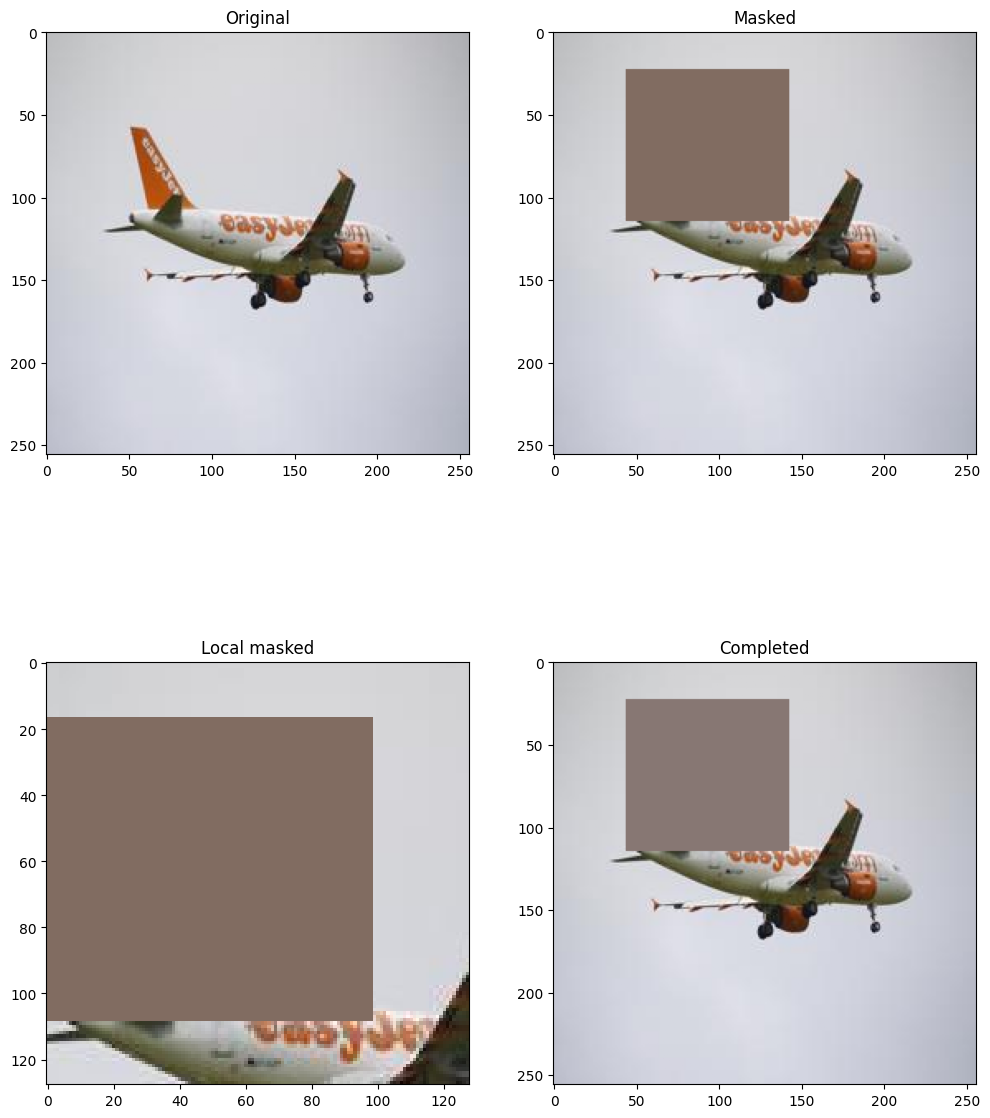

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,2, figsize=(12,15))

# display the original image
axes[0][0].imshow(batch[0].permute(1,2,0))
axes[0][0].set_title('Original')

# display the masked image
axes[0][1].imshow(masked_batch[0].permute(1,2,0))
axes[0][1].set_title('Masked')

# display the local masked image
h,h2,w,w2 = lm[0]
axes[1][0].imshow(masked_batch[0][:,h:h2,w:w2].permute(1,2,0))
axes[1][0].set_title('Local masked')

# display the completed image
axes[1][1].imshow(completed_batch[0].permute(1,2,0))
axes[1][1].set_title('Completed')

# Original otenim code

In [12]:
# import
from PIL import Image
from models import CompletionNetwork as _CN

img = Image.open("../data/train/airfield/00000004.jpg")
x = torchvision.transforms.ToTensor()(img)
x = torch.unsqueeze(x, dim=0)

model = _CN()
model.load_state_dict(torch.load("../logs/scrapped_weights/model_cn", map_location='cpu'))

<All keys matched successfully>

In [13]:
# mask
mpv = torch.tensor([0.5062325495504219, 0.4255871700324652, 0.38299278586700136])[:,None,None]
mask = em[0][None,None,:,:].repeat(1,3,1,1)
x_mask = x - x * mask + mpv * mask

In [17]:
masked_batch = apply_mask(x,em,replacement_val)

In [18]:
masked_batch

tensor([[[[0.5333, 0.5333, 0.5333,  ..., 0.5686, 0.5686, 0.5686],
          [0.5333, 0.5333, 0.5333,  ..., 0.5686, 0.5686, 0.5686],
          [0.5294, 0.5294, 0.5294,  ..., 0.5647, 0.5647, 0.5647],
          ...,
          [0.5451, 0.5451, 0.5490,  ..., 0.5608, 0.5608, 0.5647],
          [0.5451, 0.5490, 0.5490,  ..., 0.5451, 0.5490, 0.5490],
          [0.5569, 0.5608, 0.5647,  ..., 0.5529, 0.5529, 0.5529]],

         [[0.6235, 0.6235, 0.6235,  ..., 0.6392, 0.6392, 0.6392],
          [0.6235, 0.6235, 0.6235,  ..., 0.6392, 0.6353, 0.6392],
          [0.6196, 0.6196, 0.6196,  ..., 0.6392, 0.6392, 0.6392],
          ...,
          [0.5059, 0.5059, 0.5098,  ..., 0.5294, 0.5294, 0.5333],
          [0.5059, 0.5098, 0.5098,  ..., 0.5216, 0.5255, 0.5255],
          [0.5176, 0.5216, 0.5255,  ..., 0.5294, 0.5294, 0.5294]],

         [[0.6863, 0.6863, 0.6863,  ..., 0.6549, 0.6549, 0.6549],
          [0.6863, 0.6863, 0.6863,  ..., 0.6549, 0.6627, 0.6549],
          [0.6824, 0.6824, 0.6824,  ..., 0

In [16]:
x_mask

tensor([[[[0.5333, 0.5333, 0.5333,  ..., 0.5686, 0.5686, 0.5686],
          [0.5333, 0.5333, 0.5333,  ..., 0.5686, 0.5686, 0.5686],
          [0.5294, 0.5294, 0.5294,  ..., 0.5647, 0.5647, 0.5647],
          ...,
          [0.5451, 0.5451, 0.5490,  ..., 0.5608, 0.5608, 0.5647],
          [0.5451, 0.5490, 0.5490,  ..., 0.5451, 0.5490, 0.5490],
          [0.5569, 0.5608, 0.5647,  ..., 0.5529, 0.5529, 0.5529]],

         [[0.6235, 0.6235, 0.6235,  ..., 0.6392, 0.6392, 0.6392],
          [0.6235, 0.6235, 0.6235,  ..., 0.6392, 0.6353, 0.6392],
          [0.6196, 0.6196, 0.6196,  ..., 0.6392, 0.6392, 0.6392],
          ...,
          [0.5059, 0.5059, 0.5098,  ..., 0.5294, 0.5294, 0.5333],
          [0.5059, 0.5098, 0.5098,  ..., 0.5216, 0.5255, 0.5255],
          [0.5176, 0.5216, 0.5255,  ..., 0.5294, 0.5294, 0.5294]],

         [[0.6863, 0.6863, 0.6863,  ..., 0.6549, 0.6549, 0.6549],
          [0.6863, 0.6863, 0.6863,  ..., 0.6549, 0.6627, 0.6549],
          [0.6824, 0.6824, 0.6824,  ..., 0

In [15]:
sum(sum(sum((x_mask[0] - masked_batch[0])**2)))

tensor(25246.7559)

In [12]:
# complete
output = model(torch.cat((x_mask,em[0][None,None,:,:]),dim=1)).detach()
x_completed = torch.where(_em[0], output[0], x[0])

Text(0.5, 1.0, 'Completed')

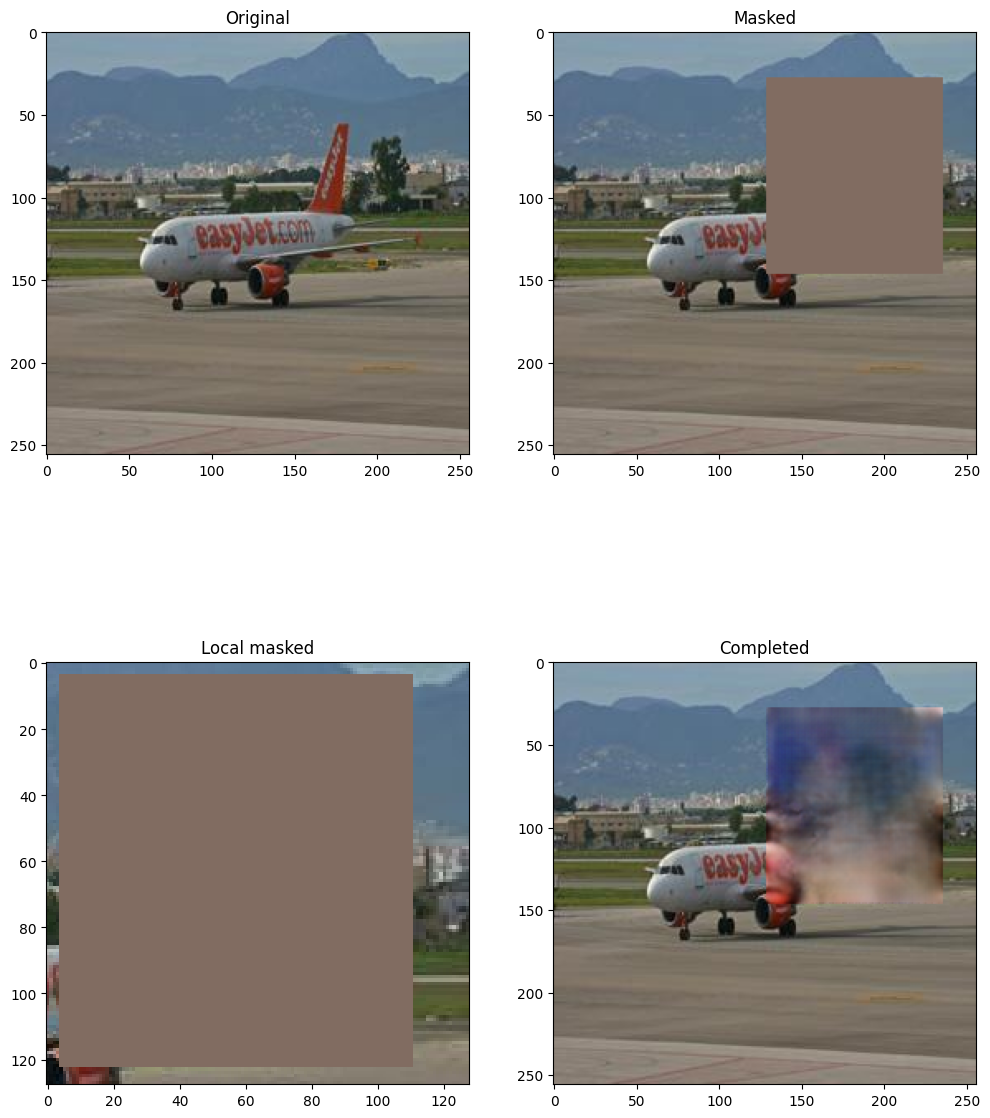

In [13]:
fig, axes = plt.subplots(2,2, figsize=(12,15))

# display the original image
axes[0][0].imshow(x[0].permute(1,2,0))
axes[0][0].set_title('Original')

# display the masked image
axes[0][1].imshow(x_mask[0].permute(1,2,0))
axes[0][1].set_title('Masked')

# display the local masked image
h,h2,w,w2 = lm[0]
axes[1][0].imshow(x_mask[0][:,h:h2,w:w2].permute(1,2,0))
axes[1][0].set_title('Local masked')

# display the completed image
axes[1][1].imshow(x_completed.permute(1,2,0))
axes[1][1].set_title('Completed')